<a href="https://colab.research.google.com/github/CurlyNikolai/Citybike_ml/blob/main/city_bike_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Bike Machine Learning

Welcome to the city bike machine learning project!

In [6]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor, Perceptron    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error    
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import calendar
int_to_weekday_map = {0 : "Mon", 1 : "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

In [7]:
# RUN THIS IF ON GOOGLE COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd  gdrive/My Drive/Aalto Game Design/Ml_intro/Citybike_ml
# ! ls

## The Data

### Read in the data
Let's start of by reading in the data, and taking a little peek of it:

In [8]:
# Read in data and take a peek 
data = pd.read_csv("bike_data.csv", index_col=0)
pd.set_option("expand_frame_repr", False)
data = data[data["Departures"]>0]
print(data)

        Year  Month  Day  Hour   Date  Weekday  Departures  Returns  Air temperature  Rain intensity  Rain intensity class
468     2016      5    2    15  05-02        0         4.0      2.0             15.5             0.0                   0.0
469     2016      5    2    15  05-02        0         4.0      2.0             15.5             0.0                   0.0
480     2016      5    2    16  05-02        0         2.0      2.0             15.3             0.0                   0.0
481     2016      5    2    16  05-02        0         2.0      2.0             15.3             0.0                   0.0
492     2016      5    2    17  05-02        0         2.0      3.0             12.6             0.0                   0.0
...      ...    ...  ...   ...    ...      ...         ...      ...              ...             ...                   ...
185198  2021     10   31    17  10-31        6         2.0      1.0              9.8             0.0                   0.0
185210  2021    

### Data visualization

Next, let's visualize the data by plotting the number of departures against most features:

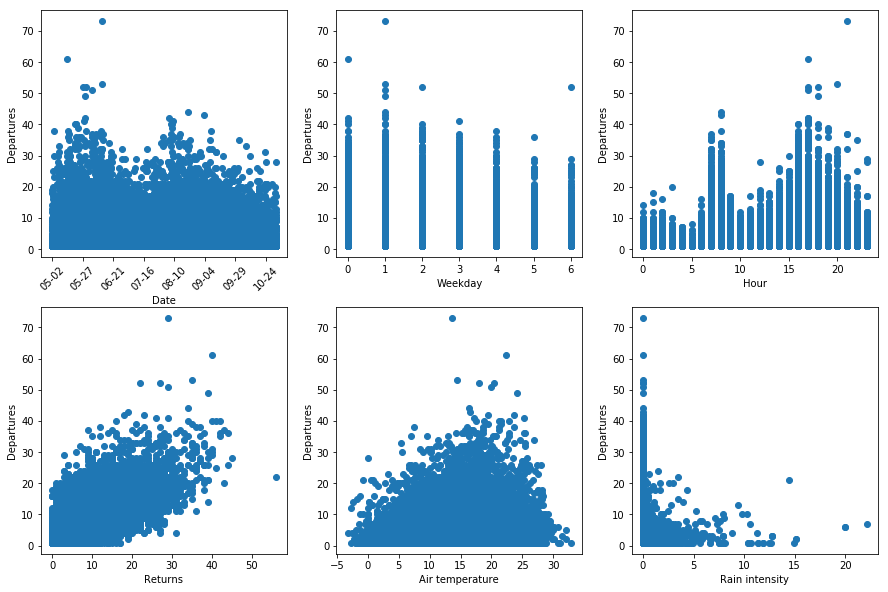

In [9]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures)
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures)
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures)
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures)
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures)
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures)
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()

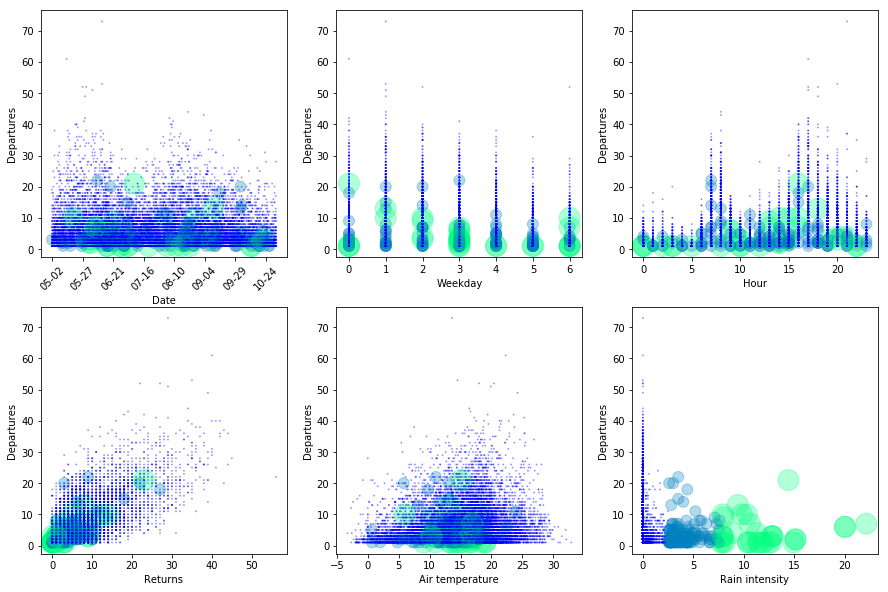

In [10]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()


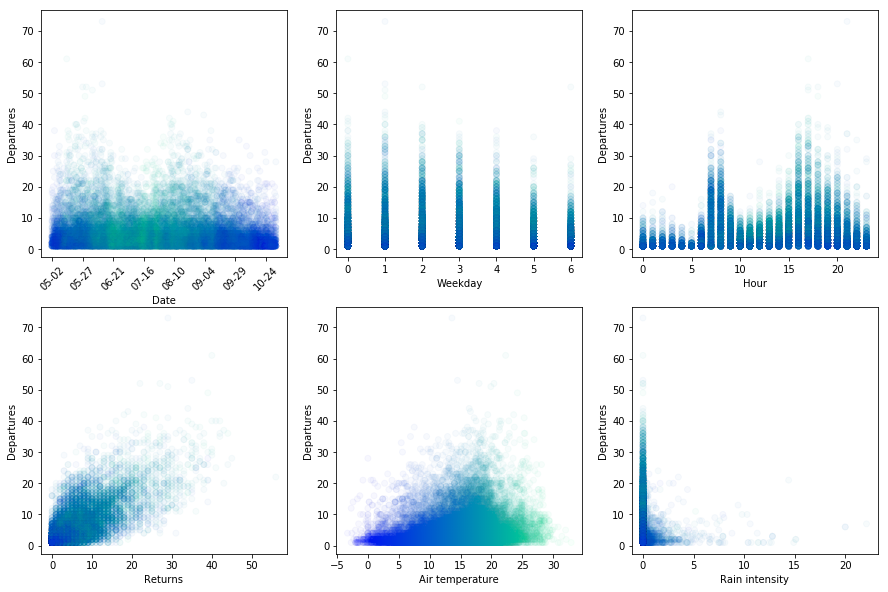

In [11]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()

Let's then look at this same plot, for each year of measurements. Let's also add some transparency to the data points in order to get a better idea of the density of points. 

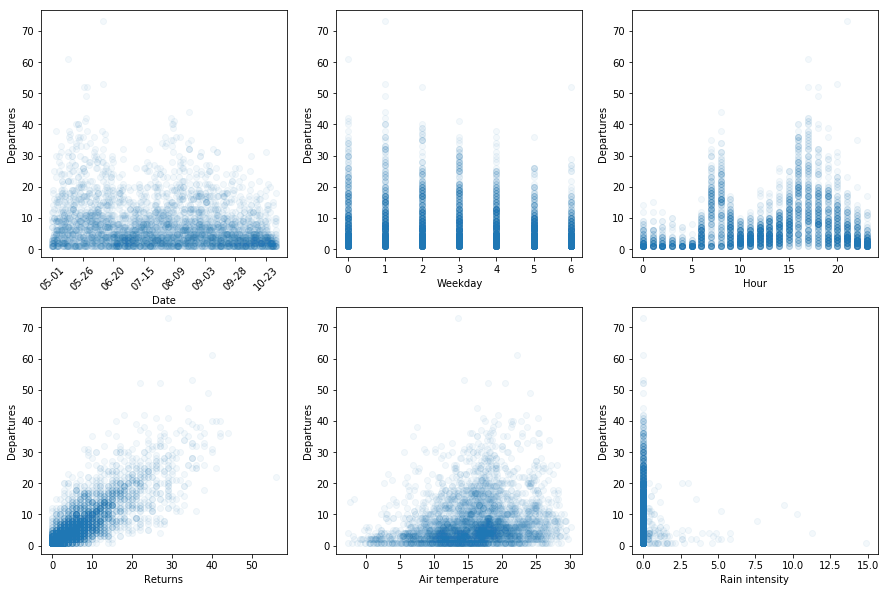

In [12]:
data_year = {i : data[data.Year==i] for i in range(2016, 2022)}

year = 2018

fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data_year[year].Date, data_year[year].Departures, alpha=0.05)
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data_year[year].Weekday, data_year[year].Departures, alpha=0.05)
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data_year[year].Hour, data_year[year].Departures, alpha=0.05)
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data_year[year].Returns, data_year[year].Departures, alpha=0.05)
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data_year[year]["Air temperature"], data_year[year].Departures, alpha=0.05)
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data_year[year]["Rain intensity"], data_year[year].Departures, alpha=0.05)
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()


Let's now plot the departures against the hour of day, for every weekday:

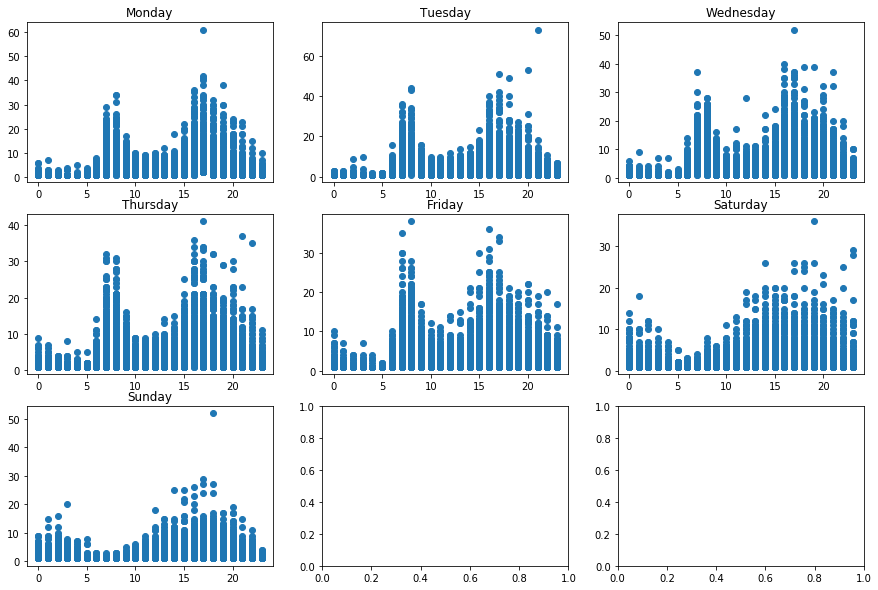

In [13]:
# Separate data into weekday data
data_weekday = [data[data.Weekday == i] for i in range(7)]

# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(3,3)
fig.set_figwidth(15); fig.set_figheight(10)
j, k = 0, 0
for i in range(7):
    if k==3: k = 0; j += 1
    axs[j, k].scatter(data_weekday[i].Hour, data_weekday[i].Departures)
    axs[j, k].set_title(list(calendar.day_name)[i])
    k+=1
plt.show()


What's interesting to see in the plot above is that we can clearly distuingish rush hours during the weekdays, and what's even more interesting to see is the little bump in departures during the night at the end of the week 😊


Now let's add a categorized value for the number of departures. We'll split the departures into three new ones: 0) Low activity, 1) Medium activity, and 3) High activity, with intervalls of 0-5, 5-15, and >15 departures, respectively.

In [14]:
# Categorize departures
departure_categories = [0, 1, 2]
cut_bins = [0, 5, 15, 1000]
categorized_departures = pd.cut(data['Departures'], bins=cut_bins, labels=departure_categories, include_lowest=True)

data["Categorized departures"] = categorized_departures


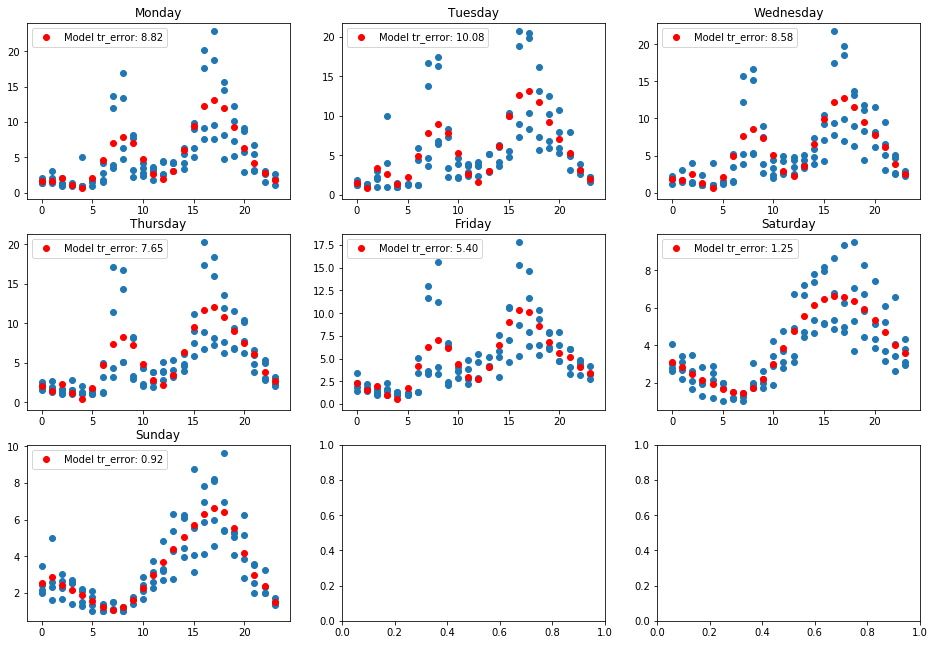

In [23]:
# Separate data into weekday data
data_weekday = [data[ (data.Weekday == i) & (data.Year>2017) ] for i in range(7)]

fig, axs = plt.subplots(3,3)
fig.set_figwidth(16); fig.set_figheight(11)
j, k = 0, 0

for i in range(7):
    if k==3: k = 0; j += 1
    y = data_weekday[i].groupby(["Hour", "Year"]).Departures.mean().to_numpy()
    X = data_weekday[i].groupby(["Hour", "Year"]).Departures.mean().index.get_level_values(0).to_numpy().reshape(-1, 1)

    poly = PolynomialFeatures(degree=10)
    X_poly = poly.fit_transform(X)
    
    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_poly, y)
    
    y_pred = lin_regr.predict(X_poly)
    tr_error = mean_squared_error(y, y_pred)

    X_fit = np.linspace(0, 23, 24)    # generate samples

    axs[j, k].scatter(X, y)
    axs[j, k].set_title(list(calendar.day_name)[i])
    axs[j, k].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="red", label="Model tr_error: {:.2f}".format(tr_error))
    axs[j, k].legend()
    k+=1
plt.show()

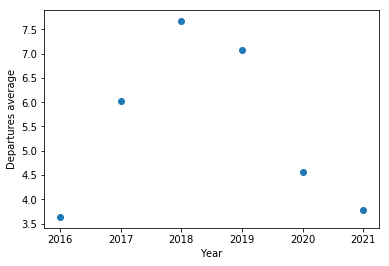

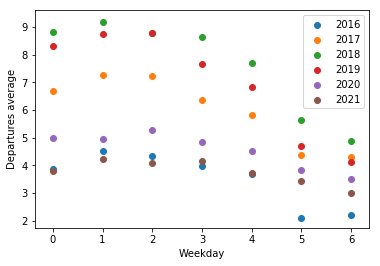

In [ ]:
# Cell for investigating the popularity of bikes at Kaisaniemi, depending on year, and weekday on different years

data_grouped_mean = data.groupby(["Year"]).Departures.mean()
year = data_grouped_mean.index.to_numpy()
value = data_grouped_mean[year].values
plt.scatter(year, value)
plt.xlabel("Year")
plt.ylabel("Departures average")
plt.show()

data_grouped_mean = data.groupby(["Year", "Weekday"]).Departures.mean()
for year in range(2016, 2022):
    day = data_grouped_mean[year].index.to_numpy()
    value = data_grouped_mean[year].values
    plt.scatter(day, value, label=year)
plt.xlabel("Weekday")
plt.ylabel("Departures average")
plt.legend()
plt.show()


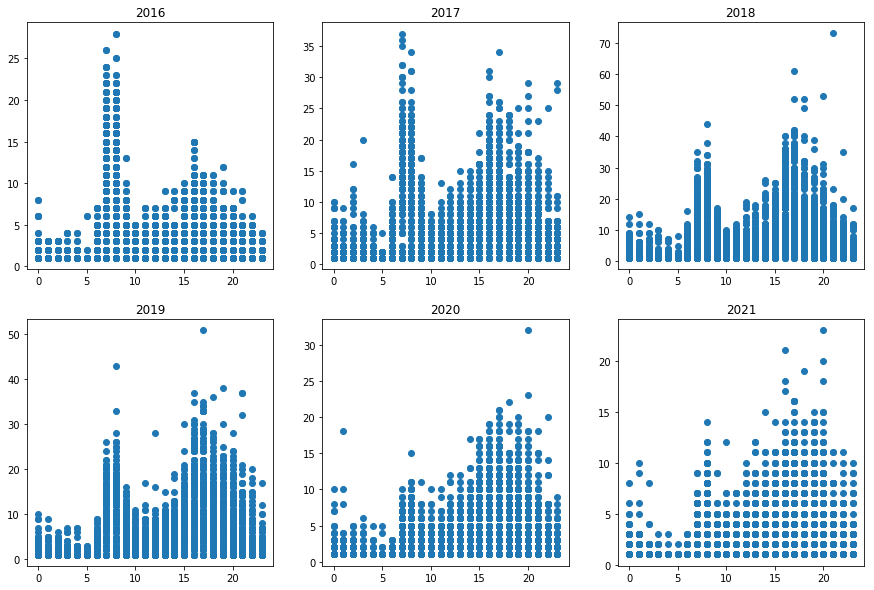

In [ ]:
# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
j, k = 0, 0
for i in range(2016, 2022):
    if k == 3:
        k = 0
        j += 1
    axs[j, k].scatter(data[data.Year==i].Hour, data[data.Year==i].Departures)
    axs[j, k].set_title(i)
    k += 1
plt.show()


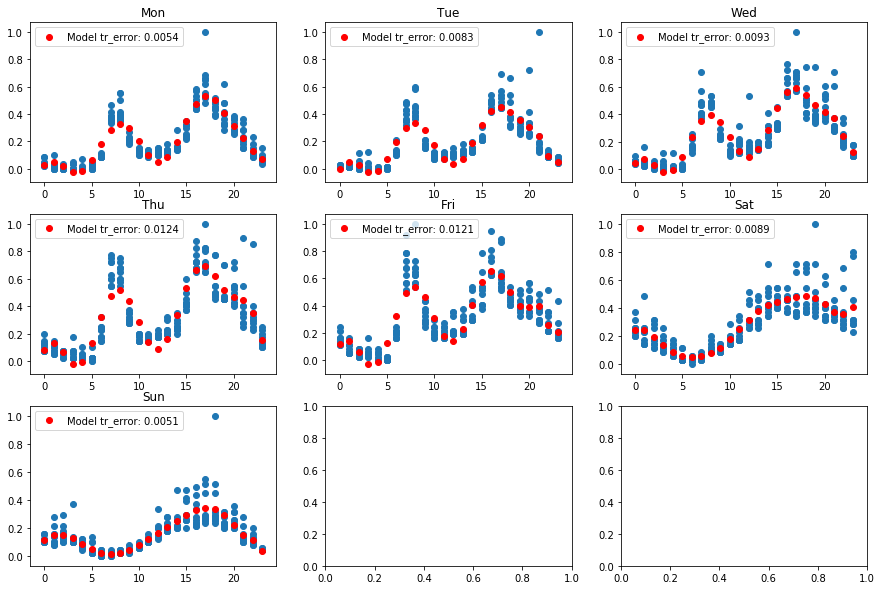

In [30]:

# Normalize the departure data for every year, to take into account stuff like, oh I don't know, A PANDEMIC!!

data_largest = data.groupby(["Weekday", "Hour"]).Departures.nlargest(10)

fig, axs = plt.subplots(3, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
j, k = 0, 0

for day in range(7):
    y = data_largest[day].values.reshape(-1, 1)
    X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)
    minmax = MinMaxScaler()
    y_scaled = minmax.fit_transform(y)

    poly = PolynomialFeatures(degree=11)
    X_poly = poly.fit_transform(X)

    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_poly, y_scaled)

    y_pred = lin_regr.predict(X_poly)
    tr_error = mean_squared_error(y_scaled, y_pred)

    X_fit = np.linspace(0, 23, 24)    # generate samples

    if k == 3:
        k = 0
        j += 1

    axs[j, k].scatter(X, y_scaled)
    axs[j, k].set_title(int_to_weekday_map[day])
    axs[j, k].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="red", label="Model tr_error: {:.4f}".format(tr_error))
    axs[j, k].legend(loc='upper left')
    k += 1

plt.show()
